**Convolutional Layers**

Used to work on 3d volumes of data like images. Idea is to learn a line detector that slides over image called a convolution.

Zero padding is to pag the convoltion image with zeroes to align centre of kernal with corners.

Output value is an element wise multiplication between kernel and grid values and current location and sum result.

Stride of convultion defines how kernel moves on the grid.

Possible to also add a bias term to each kernel in practice.

Once output created then passed into activation function (relu).

**Depth of the convolutional later**

In practice usually have several kernels that learn to detect different patterns and hence get different grid of outputs/activations. The *DEPTH* of a convolutional layer refers to number of kernels.

**Max Pooling Layers**

One of the most common pooling operations is max pooling which computes max of values in each window.

**TensorFlow Implementation**

In [3]:
import numpy as np

# load data
with np.load("c4_mnist-20k.npz", allow_pickle=False) as npz_file:
    mnist= dict(npz_file.items())
    
# convert pixels into floating point numbers
data = mnist["data"].astype(np.float32)

# rescale pixel values between -0.5 and 0.5
data = (data - 128) / 255

In [4]:
from sklearn.model_selection import train_test_split

# Split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    # Reshape images (28 by 28)
    data.reshape(-1, 28, 28, 1),  # Single channel (grayscale)
    mnist["labels"],
    test_size=500,
    random_state=0,
)

# Print shape
print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)

Train: (19500, 28, 28, 1) (19500,)
Valid: (500, 28, 28, 1) (500,)


Code above reshapes flat matrix of image pixels back into 28x28x1 grids of values resulting in two 4 dimensional arrays.

Note: The last dimension, in this case representing the grayscale channel, is very important for ConvNets. It needs to be specified even if it only has a single value, as in our example.

*Define Covolutional layer*

In [6]:
import tensorflow as tf

# Convolutional layer
conv_layer = tf.keras.layers.Conv2D(
    filters=16,
    kernel_size=(5, 5),
    strides=(2, 2),
    padding="SAME",
    activation=tf.nn.relu,
    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=0),
    name="conv",  # Add name
)
conv_output = conv_layer(X_train)

print(conv_output.shape)

(19500, 14, 14, 16)


In [7]:
print(conv_layer.kernel.shape)
print(conv_layer.bias.shape)

(5, 5, 1, 16)
(16,)


*Max pooling layer*

In [8]:
# Max pooling layer
pool_layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="SAME")
pool_output = pool_layer(conv_output)

print(pool_output.shape)

(19500, 7, 7, 16)


As we can see, the max pooling layer reduced by half the dimensions of the input in the height/width axes and hence by 75% the number of values.

*Convolutional neural network*

In [9]:
# 2nd convolutional layer
conv_layer2 = tf.keras.layers.Conv2D(
    filters=16,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="SAME",
    activation=tf.nn.relu,
    kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=0),
    name="conv2",
)
conv_output2 = conv_layer2(pool_output)

# 2nd max pooling layer
pool_output2 = pool_layer(conv_output2)

print(conv_output2.shape)
print(pool_output2.shape)

(19500, 7, 7, 16)
(19500, 4, 4, 16)


Now to combine these values into ten output logits with fully-connected layer.

In [11]:
# Flatten output
flat_layer = tf.keras.layers.Flatten()
flat_output = flat_layer(pool_output2)

print(flat_output.shape)

(19500, 256)


Now build final classifier using fullt-connected layer.

In [12]:
# Output layer
logits_layer = tf.keras.layers.Dense(
    units=10,
    activation=None,  # No activation function
    kernel_initializer=tf.keras.initializers.VarianceScaling(scale=1, seed=0),
    bias_initializer=tf.zeros_initializer(),
    name="dense",
)
logits_output = logits_layer(flat_output)

print(logits_output.shape)

(19500, 10)


**Loss function and training operations**

Adam optimizer key difference with stochastic gradient descent is that it maintains different learning rate for each parameter in the network.

In [13]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Define functions used to train the graph

# Compute the logits
@tf.function
def compute_logits(x):
    conv_output = conv_layer(x)
    pool_output = pool_layer(conv_output)
    conv_output2 = conv_layer2(pool_output)
    pool_output2 = pool_layer(conv_output2)
    flat_output = flat_layer(pool_output2)
    logits_output = logits_layer(flat_output)
    return logits_output


# Compute the loss
@tf.function
def compute_loss(y, logits):
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    mean_ce = tf.reduce_mean(ce)
    return mean_ce


# Compute the accuracy
@tf.function
def compute_accuracy(y, logits):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    return acc


# Train the model (optimization procedure)
@tf.function
def train(x, y):
    with tf.GradientTape() as tape:
        logits = compute_logits(x)
        loss = compute_loss(y, logits)
    # Concatenate the trainable variables in one list using the '+' operation on lists
    variables = (
        conv_layer.trainable_variables
        + conv_layer2.trainable_variables
        + logits_layer.trainable_variables
    )
    optimizer.minimize(loss=loss, var_list=variables, tape=tape)
    return logits, loss

*Train Network*

In [14]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y))  # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i : i + batch_size]
        yield X[batch_idx], y[batch_idx]

In [15]:
# Validation accuracy
valid_acc_values = []

# Set seed
np.random.seed(0)

# Train several epochs
for epoch in range(10):
    # Accuracy values (train) after each batch
    batch_acc = []

    # Get batches of data
    for X_batch, y_batch in get_batches(X_train, y_train, 64):
        # Run training
        batch_logits, _ = train(X_batch, y_batch)

        # Evaluate training accuracy (on current batch)
        acc = compute_accuracy(y_batch, batch_logits)
        batch_acc.append(acc)

    # Evaluate validation accuracy (on the whole data)
    valid_logits = compute_logits(X_valid)
    valid_acc = compute_accuracy(y_valid, valid_logits)
    valid_acc_values.append(valid_acc)

    # Print progress
    print(
        "Epoch {} - valid: {:.3f} train: {:.3f} (mean)".format(
            epoch + 1, valid_acc, np.mean(batch_acc)
        )
    )

# Get 1st conv. layer kernels
kernels = conv_layer.kernel

Epoch 1 - valid: 0.922 train: 0.752 (mean)
Epoch 2 - valid: 0.956 train: 0.937 (mean)
Epoch 3 - valid: 0.962 train: 0.952 (mean)
Epoch 4 - valid: 0.968 train: 0.959 (mean)
Epoch 5 - valid: 0.972 train: 0.968 (mean)
Epoch 6 - valid: 0.970 train: 0.971 (mean)
Epoch 7 - valid: 0.976 train: 0.974 (mean)
Epoch 8 - valid: 0.976 train: 0.976 (mean)
Epoch 9 - valid: 0.974 train: 0.976 (mean)
Epoch 10 - valid: 0.982 train: 0.980 (mean)


Train and validation accuracy values are close to each other which is a good sign that the network is not overfitting.

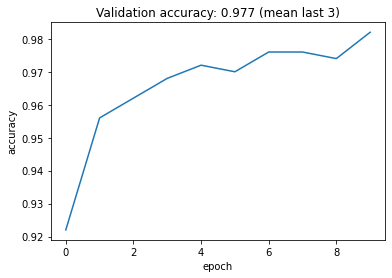

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title(
    "Validation accuracy: {:.3f} (mean last 3)".format(
        np.mean(valid_acc_values[-3:])  # Last three values
    )
)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

We get a final validation accuracy around 98%.

**Plot Filters**

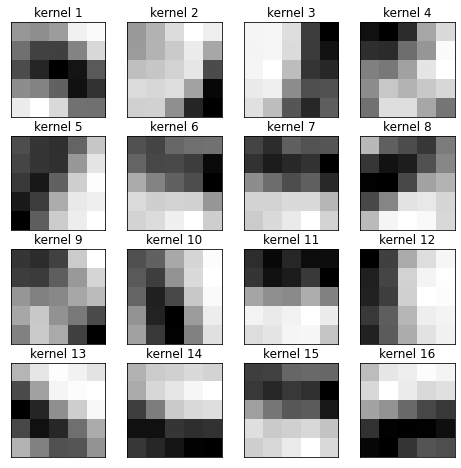

In [17]:
# Create figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Plot the 16 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel
    kernel = kernels[:, :, :, i].numpy()

    # Kernels are 5x5x1 (height, width, channels)
    # Remove last dimension
    kernel = kernel[:, :, 0]  # (5, 5) kernel

    # Plot kernel with imshow()
    axis.set_title("kernel {}".format(i + 1))
    axis.imshow(kernel, cmap=plt.cm.gray_r)
    axis.get_xaxis().set_visible(False)  # disable x-axis
    axis.get_yaxis().set_visible(False)  # disable y-axis

plt.show()

**Need to work out exercise solution**